In [ ]:
CODE FOR 5 RUNS for best set of parameters

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4


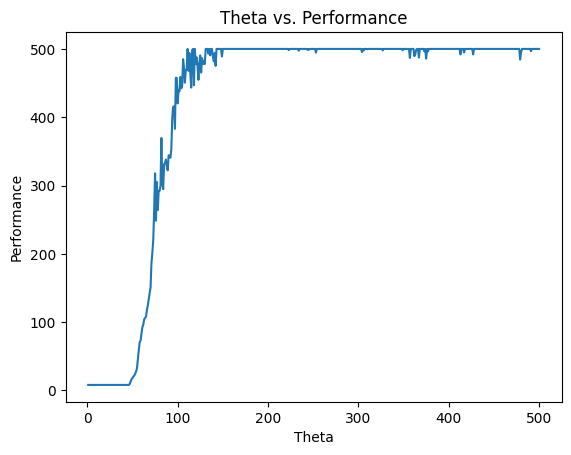

In [15]:
import numpy as np
from matplotlib import pyplot as plt

class CartPole:
    def __init__(self, M, nPerturbations, N_episodes, sigma_exploration, alpha):
        self.M = M
        self.nPerturbations = nPerturbations
        self.N_episodes = N_episodes
        self.sigma_exploration = sigma_exploration
        self.alpha = alpha
        self.policy_dimensions = [4 * self.M + 1, 1]
        self.initial_policy = np.random.rand(*self.policy_dimensions)
        self.g = 9.8
        self.m_c = 1.0
        self.m_p = 0.1
        self.m_t = 1.1
        self.l = 0.5
        self.tou = 0.02

     # def idmatrix(self):
     #    n = 4 * self.M + 1
     #    identity_matrix = np.identity(n)
     #    return identity_matrix

    def evolution_Strategies(self):
        policy = self.initial_policy
        J_list = []
        for t in range(450): #we can decide
            J_i_Epsilon_i_sum = 0
            
            J = self.estimate_J(policy)
            J_list.append(J)
            
            for i in range(0, self.nPerturbations):
                
                Epsilon = np.random.multivariate_normal(mean=np.zeros(4 * self.M + 1), cov=np.identity(4 * self.M + 1))
                Epsilon = Epsilon.reshape(-1,1)
                # print("policy here", policy.shape)
                # print("Epsilon", Epsilon.shape)
                
                perturbed_policy = policy + self.sigma_exploration*Epsilon
                # print("phi_perturbed", perturbed_policy.shape)
                
                J_i = self.estimate_J(perturbed_policy)
                
                Ji_Ei = J_i * Epsilon
                J_i_Epsilon_i_sum += Ji_Ei
                # print("jiei sum",J_i_Epsilon_i_sum)
        
            
            policy_tplus1 = policy + alpha*(1/(self.sigma_exploration*self.nPerturbations))*J_i_Epsilon_i_sum
            policy = policy_tplus1
            # print("policy next state", policy_tplus1)
        return J_list

    def normalize(self, x, v, omega, omega_dot):

        n_x = (x - 2.4) / 4.8
        n_v = (v - 3.5) / 7.0
        n_omega = (omega - (np.pi/15))/ 2*(np.pi/15)
        n_omega_dot = (omega_dot - 3.5) / 7.0

        return n_x, n_v, n_omega, n_omega_dot
        
    def compute_phi(self, state, basis):
        x, v, omega, omega_dot = state
        #normalize x,v,omega, omegadot
        n_x, n_v, n_omega, n_omega_dot = self.normalize(x, v, omega, omega_dot)
        
        if basis == "cosine":
            components = [1] + [np.cos(k * np.pi * n_x) for k in range(1, M + 1)] + \
                    [np.cos(k * np.pi * n_v) for k in range(1, M + 1)] + \
                    [np.cos(k * np.pi * n_omega) for k in range(1, M + 1)] + \
                    [np.cos(k * np.pi * n_omega_dot) for k in range(1, M + 1)]
        if basis == "sine":
            components = [1] + [np.sin(k * np.pi * n_x) for k in range(1, M + 1)] + \
                    [np.sin(k * np.pi * n_v) for k in range(1, M + 1)] + \
                    [np.sin(k * np.pi * n_omega) for k in range(1, M + 1)] + \
                    [np.sin(k * np.pi * n_omega_dot) for k in range(1, M + 1)]
            
        # print("component", components) 
        phi = np.array(components).T
        # print("phi", phi.shape)
        return phi

    def generate_action(self, state, policy):
        phi_state = self.compute_phi(state, basis="cosine") 
        
        transpose_phi_state = phi_state.reshape(-1,1).T
        # print("transpose phi",transpose_phi_state.shape)
   
        threshold = np.dot(transpose_phi_state,policy)
        # print(threshold.shape)
        
        if threshold <= 0:
            action = 'left'
        else:
            action = 'right'
        return action
        
    def calc_b(self, F, state):
        x, v, omega, omega_dot = state
        b = (F + (self.m_p*self.l*(omega_dot**2)*np.sin(omega)))/self.m_t
        return b
        
    def calc_c(self, F, state, b):
        x, v, omega, omega_dot = state
        c = ((self.g * np.sin(omega)) - (np.cos(omega) * b))/(self.l*((4/3)-((self.m_p*(np.cos(omega)**2))/self.m_t)))
        return c
        
    def calc_d(self, F, state, b, c):
        x, v, omega, omega_dot = state
        d = b - ((self.m_p*self.l*c*np.cos(omega))/self.m_t)
        return d
        
    # generate next states by calculating intermediate variables
    def calculate_bcd(self, action, state):
        if action == 'left':
            F = -10
        if action == 'right':
            F = 10
        b = self.calc_b(F, state)
        c = self.calc_c(F, state, b)
        d = self.calc_d(F, state, b, c)
        return b,c,d

    def generate_next_state(self, state, c, d):
        terminal = 0
        x, v, omega, omega_dot = state
        
        x_next = x + self.tou*v
        v_next = v + self.tou*d
        omega_next = omega + self.tou*omega_dot
        omega_dot_next = omega_dot + self.tou*c

        if (2.4 < x_next)  or (x_next < -2.4) or (np.pi/15 < omega_next) or (omega_next < -np.pi/15):
            terminal = 1
        
        next_state = (x_next, v_next, omega_next, omega_dot_next)
        
        return next_state, terminal
        
    def estimate_J(self, policy):
        G_list = []
        reward = 1
        gamma = 1
        for i in range(self.N_episodes):#need to include terminal conditions
            G_episode = 0
            initial_state = (0,0,0,0)
            state = initial_state
            
            for t in range(500):
                #loop for terminal conditions
                action = self.generate_action(state, policy)
                b,c,d = self.calculate_bcd(action, state) 
                state, terminal = self.generate_next_state(state, c, d)

                if terminal == 1:
                    break
                
                G_episode += gamma*reward
                
            G_list.append(G_episode)
            
        J_performance = np.mean(G_list)
        # print("J performance",J_performance)
        return J_performance

M, nPerturbations, N_episodes, sigma_exploration, alpha = 5, 60, 1, 0.6, 0.001
cartpole = CartPole(M, nPerturbations, N_episodes, sigma_exploration, alpha)
# J_list_ES = cartpole.evolution_Strategies()
J_list = []

for i in range(0,5):
    J_list_ES = cartpole.evolution_Strategies()
    J_list.append(J_list_ES)
    print("iteration",i)

average_J_list = np.mean(J_list, axis=0)
theta = range(1, 451)  # Generate values from 1 to no of policies update in ES
# theta_labels = [f'theta_{i}' for i in theta]

plt.plot(theta, average_J_list)
plt.title('Iterations vs. Return')
plt.xlabel('Iterations by ES')
plt.ylabel('Return')
plt.show()

In [ ]:
CODE FOR 20 RUNS for best set of parameters

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19


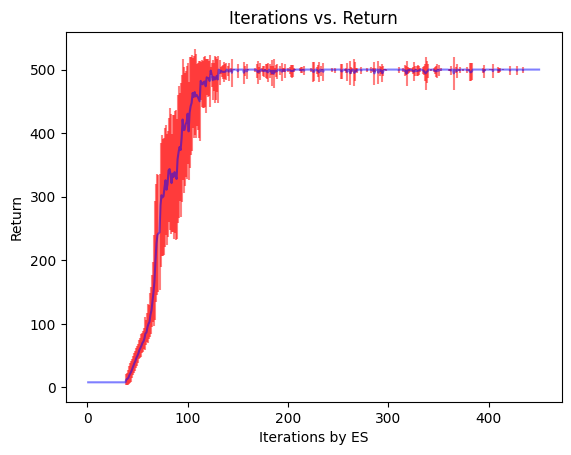

In [25]:
import numpy as np
from matplotlib import pyplot as plt

class CartPole:
    def __init__(self, M, nPerturbations, N_episodes, sigma_exploration, alpha):
        self.M = M
        self.nPerturbations = nPerturbations
        self.N_episodes = N_episodes
        self.sigma_exploration = sigma_exploration
        self.alpha = alpha
        self.policy_dimensions = [4 * self.M + 1, 1]
        self.initial_policy = np.random.rand(*self.policy_dimensions)
        self.g = 9.8
        self.m_c = 1.0
        self.m_p = 0.1
        self.m_t = 1.1
        self.l = 0.5
        self.tou = 0.02

     # def idmatrix(self):
     #    n = 4 * self.M + 1
     #    identity_matrix = np.identity(n)
     #    return identity_matrix

    def evolution_Strategies(self):
        policy = self.initial_policy
        J_list = []
        
        for t in range(450): #we can decide
            J_i_Epsilon_i_sum = 0
           
            J = self.estimate_J(policy)
            J_list.append(J)
            # print("policy here", policy.shape)
            for i in range(0, self.nPerturbations):
                
                Epsilon = np.random.multivariate_normal(mean=np.zeros(4 * self.M + 1), cov=np.identity(4 * self.M + 1))
                Epsilon = Epsilon.reshape(-1,1)
                # print("policy here", policy.shape)
                # print("Epsilon", Epsilon.shape)
                
                perturbed_policy = policy + self.sigma_exploration*Epsilon
                # print("phi_perturbed", perturbed_policy.shape)
                J_i = self.estimate_J(perturbed_policy)
               
                Ji_Ei = J_i * Epsilon
                J_i_Epsilon_i_sum += Ji_Ei
                # print("jiei sum",J_i_Epsilon_i_sum)
        
            policy_tplus1 = policy + alpha*(1/(self.sigma_exploration*self.nPerturbations))*J_i_Epsilon_i_sum
            policy = policy_tplus1
            # print("policy next state", policy_tplus1)
        return J_list

    def normalize(self, x, v, omega, omega_dot):

        n_x = (x - 2.4) / 4.8
        n_v = (v - 3.5) / 7.0
        n_omega = (omega - (np.pi/15))/ 2*(np.pi/15)
        n_omega_dot = (omega_dot - 3.5) / 7.0

        return n_x, n_v, n_omega, n_omega_dot
        
    def compute_phi(self, state, basis):
        x, v, omega, omega_dot = state
        #normalize x,v,omega, omegadot
        n_x, n_v, n_omega, n_omega_dot = self.normalize(x, v, omega, omega_dot)
        
        if basis == "cosine":
            components = [1] + [np.cos(k * np.pi * n_x) for k in range(1, M + 1)] + \
                    [np.cos(k * np.pi * n_v) for k in range(1, M + 1)] + \
                    [np.cos(k * np.pi * n_omega) for k in range(1, M + 1)] + \
                    [np.cos(k * np.pi * n_omega_dot) for k in range(1, M + 1)]
        if basis == "sine":
            components = [1] + [np.sin(k * np.pi * n_x) for k in range(1, M + 1)] + \
                    [np.sin(k * np.pi * n_v) for k in range(1, M + 1)] + \
                    [np.sin(k * np.pi * n_omega) for k in range(1, M + 1)] + \
                    [np.sin(k * np.pi * n_omega_dot) for k in range(1, M + 1)]
        # print("component", components)    
        phi = np.array(components).T
        # print("phi", phi.shape)
        return phi

    def generate_action(self, state, policy):
        phi_state = self.compute_phi(state, basis="cosine") # change state to initial/find how to 
                                                # separate initial and recurrent state
        transpose_phi_state = phi_state.reshape(-1,1).T
        # print("transpose phi",transpose_phi_state.shape)
        
        threshold = np.dot(transpose_phi_state,policy)
        # print(threshold.shape)
        
        if threshold <= 0:
            action = 'left'
        else:
            action = 'right'
        return action
        
    def calc_b(self, F, state):
        x, v, omega, omega_dot = state
        b = (F + (self.m_p*self.l*(omega_dot**2)*np.sin(omega)))/self.m_t
        return b
        
    def calc_c(self, F, state, b):
        x, v, omega, omega_dot = state
        c = ((self.g * np.sin(omega)) - (np.cos(omega) * b))/(self.l*((4/3)-((self.m_p*(np.cos(omega)**2))/self.m_t)))
        return c
        
    def calc_d(self, F, state, b, c):
        x, v, omega, omega_dot = state
        d = b - ((self.m_p*self.l*c*np.cos(omega))/self.m_t)
        return d
        
    # generate next states by calculating intermediate variables
    def calculate_bcd(self, action, state):
        if action == 'left':
            F = -10
        if action == 'right':
            F = 10
        b = self.calc_b(F, state)
        c = self.calc_c(F, state, b)
        d = self.calc_d(F, state, b, c)
        return b,c,d

    def generate_next_state(self, state, c, d):
        terminal = 0
        x, v, omega, omega_dot = state
        
        x_next = x + self.tou*v
        v_next = v + self.tou*d
        omega_next = omega + self.tou*omega_dot
        omega_dot_next = omega_dot + self.tou*c

        if (2.4 < x_next)  or (x_next < -2.4) or (np.pi/15 < omega_next) or (omega_next < -np.pi/15):
            terminal = 1
        
        next_state = (x_next, v_next, omega_next, omega_dot_next)
        
        return next_state, terminal
        
    def estimate_J(self, policy):
        G_list = []
        reward = 1
        gamma = 1
        for i in range(self.N_episodes):#need to include terminal conditions
            G_episode = 0
            initial_state = (0,0,0,0)
            state = initial_state
            
            for t in range(500):
                #loop for terminal conditions
                action = self.generate_action(state, policy)
                b,c,d = self.calculate_bcd(action, state) 
                state, terminal = self.generate_next_state(state, c, d)

                if terminal == 1:
                    break
                    
                # need to normalize x,v,omega,omega_dot here
                # need to start generating from second state for each epsidoe and adding
                # reward
                G_episode += gamma*reward
                
            G_list.append(G_episode)
            
        J_performance = np.mean(G_list)
        # print("J performance",J_performance)
        return J_performance

M, nPerturbations, N_episodes, sigma_exploration, alpha = 5, 60, 1, 0.6, 0.001
cartpole = CartPole(M, nPerturbations, N_episodes, sigma_exploration, alpha)
# J_list_ES = cartpole.evolution_Strategies()
J_list = []

for i in range(0,20):
    J_list_ES = cartpole.evolution_Strategies()
    J_list.append(J_list_ES)
    # print(J_list_ES)
    print("iteration", i)

average_J_list = np.mean(J_list, axis=0)
average_stdJ_list = np.std(J_list, axis=0)
theta = range(1, 451)  # Generate values from 1 to no of policies update in ES
# theta_labels = [f'theta_{i}' for i in theta]

plt.errorbar(theta, average_J_list, yerr=average_stdJ_list, color='blue', ecolor='red', label='Policy vs Performance', alpha = 0.5)
plt.title('Iterations vs. Return')
plt.xlabel('Iterations by ES')
plt.ylabel('Return')
plt.show()